## Simulación de medición y análisis de datos

In [1]:
#Importo librerías
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import trapezoid

from scipy import interpolate
from scipy.signal import argrelextrema
from scipy.stats import skewnorm
from scipy.optimize import least_squares
from scipy.stats import betaprime, norm
from scipy.stats import bernoulli
from scipy.integrate import quad


#Defino ctes
pi = np.pi

In [2]:
#Defino tiempo inicial y tiempo final
t_ini = 0
t_fin = 12

In [3]:
def S_A(t, t0, sigma, w):
    '''
    Señal modelo producida por el detector a tiempo t con centro t0, ancho sigma y frecuenca omega sin normalizar
    
    Paramaters
    ----------
    t (float): tiempo
    t0 (float): centro
    sigma (float): ancho
    w(float): frecuencia de oscilación

    Returns
    -------
    float: señal sin normalizar a tiempo t
    
    Nota:
    (1) El tiempo t puede ser un ndarray
    '''
    
    return np.exp( -(t-t0)**2/(2*sigma**2) )*np.cos(w*(t-t0+sigma))

def cte_A(t_array, S_A_array):
    '''
    Calcula la cte de normalización A de la señal modelo de modo que el área debajo de la curva sea unitaria. Se emplea el método de trapecios. Se asume que la señal está completamente contenida en el rango recorrido por t_array, es decir, que fuera de dicho rango la señal es aproximadamente nula.
    
    Parameters
    ----------
    t_array (ndarray): tiempo
    S_A_array (float): señal modelo no normalizada evaluada en los tiempos correspondientes a t_array
    
    Return
    ------
    A (float): cte de normalización de la señal modelo
    '''
    
    #Verificamos si la señal se encuentra en el intervalo considerado.
    if not np.allclose(S_A_array, 0, atol = 1e-3): #cae dentro del intervalo
        area = trapezoid(S_A_array, t_array)
        A = 1/area
        return A
    else: #no cae dentro del intervalo
        return 0

def S(t_array, t0, sigma, w):
    '''
    Señal modelo normalizada producida por el detector a tiempo t, centro t0, ancho sigma y frecuenca omega

    Paramaters
    ----------
    t_array (ndarray): tiempo
    t0 (float): centro
    sigma (float): ancho
    w(float): frecuencia de oscilación

    Returns
    -------
    float: señal a tiempo t
    
    Nota:
    (1) La constante A es tal que la integral del pulso es igual a 1. Para calcular la integral se emplea el método del trapecio.
    '''
    #Evalúo S sin normalizar
    S_A_array = S_A(t_array, t0, sigma, w)

    #Calculo la constante de normalización
    A = cte_A(t_array, S_A_array)

    return A*S_A_array


In [4]:
# #Grafico S para un caso particular y comparo con el gráfico del enunciado

# #Genero datos:
# M = 1000 #nro de puntos
# t_array = np.linspace(t_ini,3*t_fin, M)
# t0, sigma, w = 4, 0.05, 15
# S_array = S(t_array, t0, sigma, w)


# #Gráfico:
# plt.plot(t_array, S_array)
# plt.xlim([0,8])
# plt.show()


In [5]:
#Distribuciones

def t0_dist(t0):
    '''
    Posición de cada pico determinada por la distribución Beta prime centrada en t0 con parámetros a = 4. b = 2 y sigma_t0 = 0.15.
    
    Parameters
    ----------
    t0 (float): centro de la distribución

    Returns
    -------
    float: posición del pico
    '''
    a = 4
    b = 2
    sigma_t0 = 0.15 
    return betaprime.rvs(a = a, b = b, loc = t0, scale = sigma_t0)

def sigma_dist():
    '''
    Ancho sigma del pico central determinado por la distribución normal con valor medio sigma0 = 0.05 y desviación sigma_sigma = 0.005
    
    Parameters
    ----------
    None

    Returns
    -------
    float: ancho sigma
    '''
    sigma0 = 0.05
    sigma_sigma = 0.005
    return norm.rvs(loc = sigma0, scale = sigma_sigma)

def w_dist():
    '''
    Frecuencia de oscilación w determinada por la distribución normal con valor medio w0 = 5 pi y desviación sigma_w = 0.05
    
    Parameters
    ----------
    None

    Returns
    -------
    float: ancho sigma
    '''
    w0 = 5*pi
    sigma_w = 0.05

    return norm.rvs(loc = w0, scale = sigma_w)

def ruido_dist(señal):
    '''
    Señal de ruido a tiempo t. Está conformada por 2 componentes
    (1) Ruido relativo: dado por una distribución normal con valor medio 1 y ancho 0.1. Este se multiplica a la señal
    (2) Ruido absoluto: dado por una distribución normal con valor medio nulo y ancho 0.2. Este se suma a la señal
    Dada una señal y0, la nueva señal con ruido y es tal que y = y_0*ruido_rel + ruido_abs

    Parameters
    ----------
    señal (ndarray): valor simulado de la señal sin ruido ni fondo lineal

    Returns
    -------
    float: señal ruido

    '''
    ruido_rel = norm.rvs(loc = 1, scale = 0.1, size = len(señal))*señal
    ruido_abs = norm.rvs(loc = 0, scale = 0.2, size = len(señal))

    return ruido_rel + ruido_abs

def fondo(t):
    '''
    Señal de fondo lineal sobre la que se monta todo el espectro.
    
    Parameters
    ----------
    t (float): tiempo

    Returns
    -------
    float: valor del fondo a tiempo t

    Nota: puede aceptar ndarray como input
    '''
    
    return (-t+2)/100


In [6]:
#Grafico betaprime para ver su forma

# #Genero datos:
# T0 = 1.8
# rv = betaprime(a = 4, b = 2, loc = T0, scale = 0.15)
# t_array = np.linspace(0,8,1000)
# beta = rv.pdf(t_array)

# #Grafico:
# plt.plot(t_array, beta)
# plt.show()
# print("Máximo en t = ", t_array[np.where(beta==np.max(beta))])


### Ejercicio 1

Una medición puede estar compuesta por cualquiera de las 3 señales, cada una con una probabilidad distinta. En cada medición, la señal i con centro en t0_i tiene probabilidad P_i. En caso de darse, tengo que producir una señal S(t,t0_dist(t0), sigma_dist, w_dist)_i. Luego, le sumo el ruido y el fondo.

In [7]:
def genero_señal(T0, M):
    '''
    Produzco una señal (un pico) localizado en tiempo T0. No posee ruido ni fondo
    
    Parameters
    ----------
    T0 (float): tiempo en el que se localiza el pico
    M (int): tamaño del ndarray señal


    Returns
    -------
    señal (ndarray): array señal
    '''
    #Verifico que M sea entero TO-DO



    #Defino los parámetros característicos de la señal
    t0 = t0_dist(T0)
    sigma = sigma_dist()
    w = w_dist()

    # print(t0, sigma, w)
    
    # A = cte_A(t0,sigma,w)
    
    

    #Creo el vector de tiempos
    t_array = np.linspace(t_ini, t_fin, M)

    #Calculo la señal
    señal = S(t_array, t0, sigma, w)

    return t_array, señal


def medicion(T0_P, M):
    '''
    Simulo una medición. Para esto es necesario producir 3 señales con centros de las señales y probabilidades de ocurrencia determinados en el diccionario T0_P. Luego, es necesario sumar el ruido a la medición y el fondo.

    Parameters
    ----------
    T0_P (dic): diccionario que contiene los pares T0 (centro de la señal modelo) y P (probabilidad de ocurrencia de tal señal)
    M (int): tamaño del ndarray medicion

    Returns
    -------
    medicion (ndarray): medicion simulada
    
    '''
    #Verifico que M sea entero TO-DO



    #Creo el array de mediciones y de tiempos
    medicion = np.zeros(M)
    t_array = np.linspace(t_ini, t_fin, M)

    #Para cada señal posible
    for T0 in T0_P:
        #Tiro un dado con probabilidad P para ver si se observa la señal
        ocurrencia = bernoulli.rvs(T0_P[T0])
        # print(ocurrencia)
        if ocurrencia == True: #ocurre
            t_array, señal = genero_señal(T0, M)
            medicion += señal
    
    #Sumo ruido
    medicion += ruido_dist(medicion)   

    #Sumo fondo
    medicion += fondo(t_array)

    return t_array, medicion

In [8]:
#Grafico una señal

# #Genero datos:
# T0 = 1.8
# M = 1000
# t_array, señal = genero_señal(T0, M)
# #Grafico:
# plt.plot(t_array, señal)
# plt.xlim([0,8])
# plt.show()

In [9]:
#Grafico una medición

# #Genero datos:
# T0_P = {1.8:0.3, 2.8:0.1, 5:0.6}
# M = 1000
# t_array, medicion_array = medicion(T0_P, M)
# #Grafico:
# plt.plot(t_array, medicion_array)
# plt.ylim([-5,35])
# plt.xlim([0,8])
# plt.ylabel("Tensión (mV)")
# plt.xlabel("$tiempo \, (\mu s)$")
# plt.show()



Hago una animación

In [10]:
# %matplotlib tk #Descomentar al final TO-DO

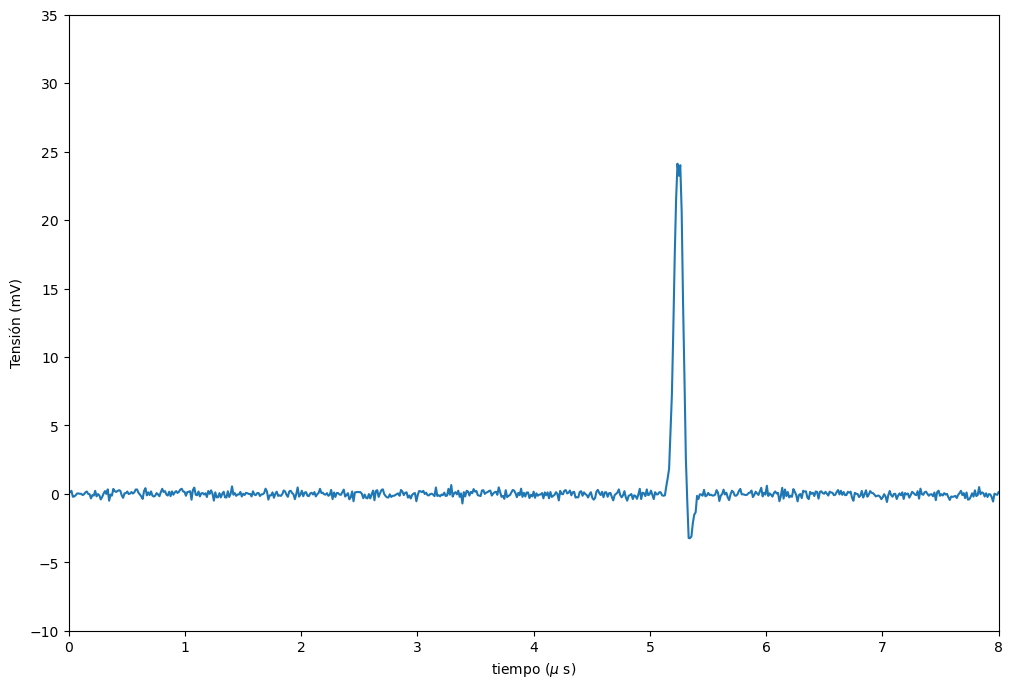

In [11]:
# plt.ioff() #Descomentar al final TO-DO

# Creamos los datos
T0_P = {1.8:0.3, 2.8:0.1, 5:0.6}
M = 1000
N_med = 10 #nro de mediciones

def update_line(num, line):
  '''
  Actualiza la medición en la animación  
  '''
  t_array, medicion_array = medicion(T0_P, M)
  line.set_data(np.vstack([t_array, medicion_array]))

  return line,

# Creo la figura e inicializo
fig1, ax = plt.subplots(figsize=(12,8))
# Grafico una línea sin puntos
L, = plt.plot([], [], '-')
# Determino características del gráfico
ax.set_ylim([-10,35])
ax.set_xlim([0,8])
ax.set_ylabel("Tensión (mV)")
ax.set_xlabel("tiempo ($\mu$ s)")
#Animación
line_ani = animation.FuncAnimation(fig1, update_line, N_med, fargs=(L,), interval=500, blit=True)

plt.show()


### Ejercicio 2

In [12]:
def mediciones(T0_P, N, M):
    '''
    Resultado de N mediciones. Calculo N mediciones con centros de las señales y probabilidades de ocurrencia determinados.

    Parameters
    ----------
    T0_P (dic): diccionario que contiene los pares T0 (centro de la señal modelo) y P (probabilidad de ocurrencia de tal señal)
    N (int): nro de mediciones simuladas
    M (int): tamaño del ndarray medicion

    Return
    ------
    t_array (ndarray de dimensión M): tiempos
    mediciones_array (ndarray de dimensión NxM): matriz donde cada fila corresponde a una medición distinta
    '''
    mediciones_array = np.empty([N, M])
    for i in range(N):
        # print(i, " de ", N)
        t_array, mediciones_array[i] = medicion(T0_P, M)

    return t_array, mediciones_array

def mediciones_mean(T0_P, N, M):
    '''
    Promedio de N mediciones con centros de las señales y probabilidades de ocurrencia determinados.

    Parameters
    ----------
    T0_P (dic): diccionario que contiene los pares T0 (centro de la señal modelo) y P (probabilidad de ocurrencia de tal señal)
    N (int): nro de mediciones simuladas
    M (int): tamaño del ndarray medicion

    Return
    ------
    t_array (ndarray de dimensión M): tiempos
    mediciones_mean_array: (ndarray de dimensión M): promedio de N mediciones

    '''
    #Genero N mediciones y devuelvo el promedio
    t_array, mediciones_array = mediciones(T0_P, N, M)
    mediciones_mean_array = np.mean(mediciones_array, axis = 0)
    
    return t_array, mediciones_mean_array
    

In [13]:
#Calculo el promedio de las mediciones y grafico

T0_P = {1.8:0.3, 2.8:0.1, 5:0.6}

N = 50000
M = 1000

t_array, mediciones_mean_array = mediciones_mean(T0_P, N, M)



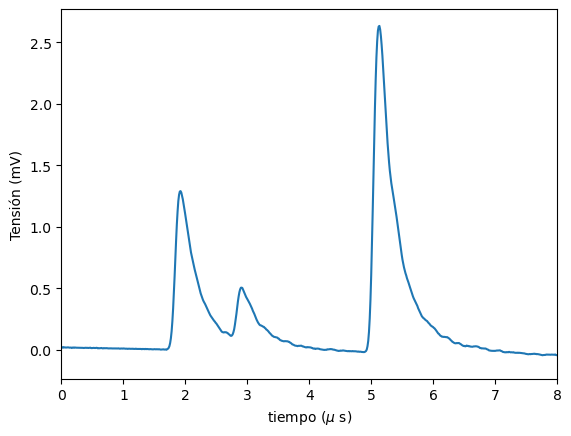

In [14]:
plt.plot(t_array, mediciones_mean_array)
#Graficar como título T0,P0 y "Promedio de N = ..." mediciones TO-DO
plt.ylabel("Tensión (mV)")
plt.xlabel("tiempo ($\mu$ s)")
plt.xlim([0,8])
plt.show()

### Ejercicios 3 y 4

Análisis de datos

El objetivo del ejercicio es simular el análisis de un conjunto de datos usando python. Así que de ahora en más trabajo sobre los datos crudos "olvidando" cómo se generaron. En análisis consta de 3 objetivos
1. Determinar la posición del máximo para cada pico. Cuando cursé Experimental recurrentemente me enfrentaba a la tarea de encontrar máximos relativos en mis datos. En su momento trabajaba con Origin y el sistema no era capaz de detectar aumtomáticamente todos los máximos relativos. No voy a esperar poder hacer esto con python. Mi objetivo será encontrar los máximos relativos con la menor intervención posible.
2. Determinar el ancho a la altura mitad
3. Suponiendo que los 3 picos tienen la misma forma, hacer un ajuste por cuadrados mínimos de una función y estimar el área de cada pico. Para tal fin hago un ajuste por mínimos cuadrados de los picos mediante una combinación lineal de distribuciones normales sesgadas. La elección de la distribución es arbitraria. La elegí en base al gráfico (dejando de lado cómo fueron generados los datos)

#### Genero datos

In [15]:
#Explicar qué está pasando en esta celda y cómo se guardaron los datos TO-DO

T0_P_1 = {1.8: 1, 2.8: 0, 5: 0}
T0_P_2 = {1.8: 0.8, 2.8: 0.1, 5: 0.1}
T0_P_3 = {1.8: 0.85, 2.8: 0.1, 3.5: 0.05}

#Calculo el promedio para cada caso
N = 50000#10000
M = 1000

T0_Ps = [T0_P_1, T0_P_2, T0_P_3]
t_array = np.empty([3,M])
mediciones_mean_array = np.empty([3,M])
for i,T0_P in enumerate(T0_Ps):
    #Calculo el promedio
    t_array[i], mediciones_mean_array[i] = mediciones_mean(T0_P, N, M)



#### Análisis

In [16]:
def max_rel(t_array, signal_mean, threshold):
    '''
    Calcula los máximos relativos en signal_mean y devuelve aproximadamente el valor de los máximos y los tiempos en los que fueron evaluados. Solo se considerarán los máximos mayores a threshold, el cual debe ser determinado mediante el gráfico (intervención del usuario).
    
    '''

    #Hacemos un suavizado de los datos para que funcione mejor la búsqueda de máximos
    # yhat = savgol_filter(mediciones_mean_array, int(M/40), 3) # window size 51, polynomial order 3
    tck = interpolate.splrep(t_array,signal_mean,s=0.1) # Aproximación suavizada
    signal_mean_smooth = interpolate.splev(t_array,tck)      # Evaluamos en la nueva grilla


    #Gráfico:
    # plt.plot(t_array, signal_mean, label = "Señal")
    # plt.plot(t_array, signal_mean_smooth, label = "Señal suavizada")
    # plt.legend()
    # plt.ylabel("Tensión (mV)")
    # plt.xlabel("$tiempo \, (\mu s)$")
    # plt.xlim([0,8])
    # plt.show()

    #Busco los máximos relativos
    max_indexes = argrelextrema(signal_mean_smooth, np.greater)
    # print(signal_mean_smooth[max_indexes*(signal_mean_smooth[max_indexes]>0)])
    
    #Evalúo t_array y signal_mean_smooth en los máximos
    threshold = 0.25

    t_maxrel = []
    maxrel = []

    for max_index in max_indexes[0]:

        #Condición threshold
        if signal_mean_smooth[max_index]>threshold:
            t_maxrel = np.append(t_maxrel,t_array[signal_mean_smooth == signal_mean_smooth[max_index]])
            maxrel = np.append(maxrel,[signal_mean[max_index]])

    return t_maxrel, maxrel
        

In [17]:
def ancho_media(t_array, signal_mean, maximums):
    '''
    Calcula el ancho a altura media de cada pico y devuelve las coordenadas de los puntos entre los que se grafica la altura media
    
    maximums es t_maxrel, maxrel

    Estoy asumiendo que se puede distinguir el pico a altura media

    Los máximos tienen que estar ubicados de izquierda a derecha

    Hacer documentación de la función TO-DO
    Cambiarla para que haga un ajuste de los datos y en función de eso se calcule el ancho a altura media TO-DO
    Aclarar qué significa "ancho a media altura" en esta función y en el markdown de Ejericio 3 y 4 más arriba TO-DO

    '''
    t_maxrel, maxrel = maximums

    anchos = {}

    index_ini = 0
    index_fin = 1

    for i in range(len(t_maxrel)):
        #Calculo la altura media
        altura_media = maxrel[i]/2

        #Recorro signal_mean y evalúo los puntos alrededor que satisfacen la condición signal_mean < altura_media
        condicion = signal_mean < altura_media
        condicion[:index_fin] = True #Para que no considere los datos correspondientes al pico anterior


        #Busco el primer false
        index_ini = np.argmin(1.*condicion)
        # print(condicion, index_ini)
        

        #Busco el primer true después del false, me quedo con el anterior
        index_fin = np.argmax(1.*condicion[index_ini:]) + index_ini - 1
        # print(index_ini, index_fin)
        # print(condicion[index_fin-5: index_fin+5])

        #Evalúo t_array en dichos puntos
        anchos[altura_media] = [t_array[index_ini], t_array[index_fin]]
        
    return anchos

#Test:
# ancho_media(t_array, mediciones_mean_array, max_rel(t_array, mediciones_mean_array, 0.25))

In [18]:
#Gráfico de la distribución normal sesgada
# def fun_skewnorm_test(x, a, scale):
#     #skewnorm tiene parámetros
#     return skewnorm.pdf(x, 3, scale = 1, loc = 2)

# x_array = np.linspace(-2,5,100)
# plt.plot(x_array, fun_skewnorm_test(x_array,5, 2))
# plt.show()


In [19]:

def fun_skewnorm(x, params):
    '''
    Documentación TO-DO
    
    '''


    #Asigno parámetros
    a, scale = params[0], params[1]
    loc1, p1 = params[2], params[3]
    loc2, p2 = params[4], params[5]
    loc3, p3 = params[6], params[7]

    # return p1*betaprime.pdf(x, a = 2, b = 4, loc = loc1, scale = scale) + p2*betaprime.pdf(x, a = 2, b = 4, loc = loc2, scale = scale) + p3*betaprime.pdf(x, a = 2, b = 4, loc = loc3, scale = scale)
    return p1*skewnorm.pdf(x, a, loc = loc1, scale = scale) + p2*skewnorm.pdf(x, a, loc = loc2, scale = scale) + p3*skewnorm.pdf(x, a, loc = loc3, scale = scale)


def ajuste_minimos_cuadrados(t_array, signal_array):
    '''
    Ajusto el promedio de las mediciones mediante una combinación lineal de distribuciones normales sesgadas.

    Retorno la función ajuste evaluada en t_array

    Documentación TO-DO
    '''

    def func_skewnorm_dif(params):
        return fun_skewnorm(t_array, params) - signal_array
    
    params0 = [3, 1, 2, 5, 3, 5, 5, 5]
    params_optimos = least_squares(func_skewnorm_dif, x0 = params0)["x"]

    return t_array, fun_skewnorm(t_array, params_optimos), params_optimos

#Test:
# t_array, mediciones_ajuste, params_optimos = ajuste_minimos_cuadrados(t_array, mediciones_mean_array)

def area_under_pico(params):
    '''
    Calculo el área debajo de cada pico
    
    Documentación TO-DO

    '''

    #Evalúo fun_skewnorm solo para cada pico
    areas = []
    for i in range(3):
        params_i = np.zeros(len(params))
        params_i[0:2] = params[0:2]
        params_i[2 + i*2:4+ i*2] = params[2+ i*2:4+ i*2]
        #Calculo el área con quad
        areas += [quad(lambda x: fun_skewnorm(x, params_i), t_ini, t_fin)[0]]

    return areas

#Test:
# area_under_pico(params_optimos)
#Grafico
# plt.plot(t_array, mediciones_mean_array, label = "Señal")
# plt.plot(t_array, mediciones_ajuste, label = "Ajuste")
# plt.legend()
# plt.ylabel("Tensión (mV)")
# plt.xlabel("$tiempo \, (\mu s)$")
# plt.xlim([0,8])
# plt.show()

In [20]:
#Ejemplo de uso de least_squares:
# def fit_func(x,params):
#   a, b, c, d = params[0], params[1], params[2], params[3]
#   ynew = a*np.sin(b*x-d)*np.exp(-c*x)
#   return ynew

# x_array = np.linspace(0., 2*np.pi, 50)
# y0 = fit_func(x, [ 1., 3., 1/3, 0 ])
# ruido = np.random.normal(loc= 0., scale= 1, size= y0.size)
# y_array = y0 + 0.1*ruido

# def fit_func_dif(params):
#   return fit_func(x_array,params) - y_array

# params_optimos = least_squares(fit_func_dif, x0 = [1., -1., 1., 0.2])["x"]


Ahora sí, calculo la señal promedio en cada caso

{2.1661261018286626: [1.8378378378378377, 2.138138138138138]}
2.1661261018286626


C:\Users\lupam\AppData\Local\Temp\ipykernel_15252\546771817.py:33: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.arrow(x_ini,altura_media, x_fin - x_ini,0, width = .03, length_includes_head = True, edgecolor = 'tab:red', color = "tab:red")
C:\Users\lupam\AppData\Local\Temp\ipykernel_15252\546771817.py:34: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.arrow(x_fin,altura_media, -(x_fin - x_ini),0, width = .03, length_includes_head = True, edgecolor = 'tab:red', color = "tab:red")


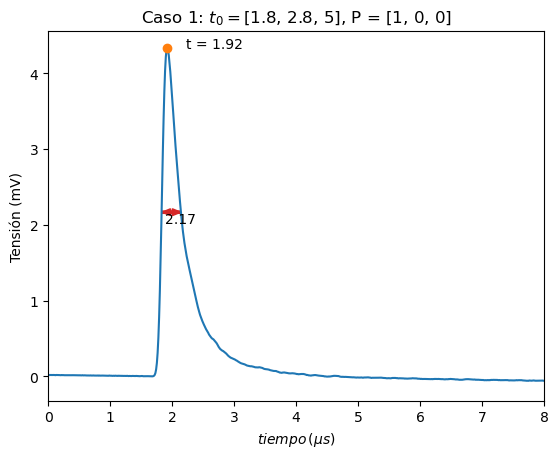

{1.7714722298853445: [1.8378378378378377, 2.138138138138138], 0.33702829025631603: [2.138138138138138, 2.7387387387387387], 0.2258652976224997: [2.7387387387387387, 3.3033033033033035]}
1.7714722298853445
0.33702829025631603
0.2258652976224997


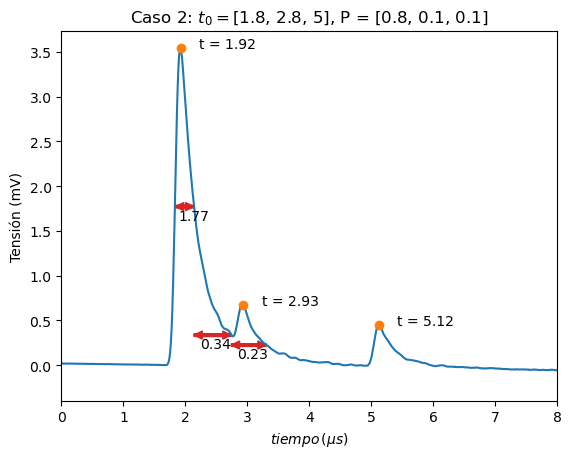

{1.8597749871415694: [1.8378378378378377, 2.138138138138138], 0.33547455742697113: [2.138138138138138, 3.183183183183183], 0.16206238569122883: [3.183183183183183, 3.8678678678678677]}
1.8597749871415694
0.33547455742697113
0.16206238569122883


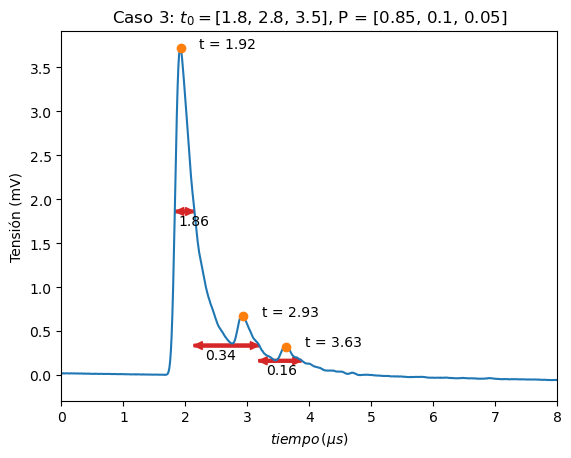

In [21]:
thresholds = [0.3, 0.1, 0.1]

for i in range(3):
    x_array = t_array[i]
    signal_mean = mediciones_mean_array[i]
    threshold = thresholds[i]

    #Grafico
    plt.plot(x_array, signal_mean, label = "Medición promedio") 
    #Agregar cuántas mediciones se promediaron TO-DO . Sacar "Caso" y reescribir T0 y P0 de forma más entendible (no como una lista)
    plt.title(f"Caso {i + 1}: $t_0 = $" + str(list(T0_Ps[i].keys())) + ", P = " + str(list(T0_Ps[i].values())))
    plt.ylabel("Tensión (mV)")
    plt.xlabel("$tiempo \, (\mu s)$")
    plt.xlim([0,8])

    #Busco los máximos relativos
    t_maxrel, maxrel = max_rel(x_array, signal_mean, threshold)

    #Grafico puntos en cada máximo junto al valor correspondiente
    plt.plot(t_maxrel, maxrel, "o") #marker=11
    for i in range(len(t_maxrel)):
        plt.text(t_maxrel[i] + 0.3, maxrel[i], f"t = {round(t_maxrel[i],2)}")

    #Calculo el ancho a mitad de altura
    anchos = ancho_media(x_array, signal_mean, (t_maxrel, maxrel))
    print(anchos)
    #Grafico el ancho como una flecha junto al valor correspondiente
    for altura_media in anchos:
        print(altura_media)
        x_ini = anchos[altura_media][0]
        x_fin = anchos[altura_media][1]
        # print(x_ini, x_fin)
        plt.arrow(x_ini,altura_media, x_fin - x_ini,0, width = .03, length_includes_head = True, edgecolor = 'tab:red', color = "tab:red")
        plt.arrow(x_fin,altura_media, -(x_fin - x_ini),0, width = .03, length_includes_head = True, edgecolor = 'tab:red', color = "tab:red")

        plt.text((x_fin+x_ini)/2 - (x_fin-x_ini)/3, altura_media - 0.15, str(round(altura_media,2)))

    plt.show()

(0.0, 8.0)

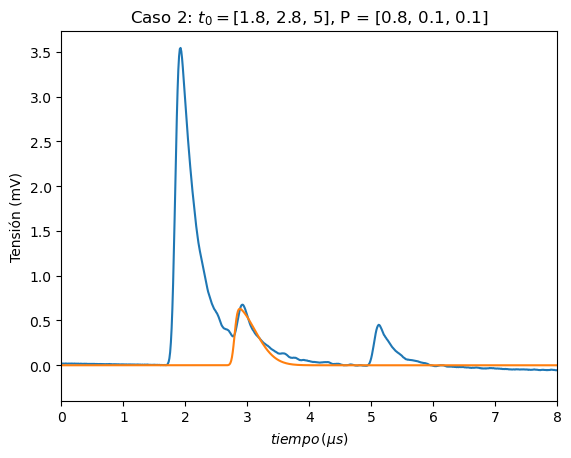

In [22]:
#Grafico cada medición promedio junto con los ajustes de cada pico
#Terminar de hacer los gráficos TO-DO
#Poner labels correspondientes TO-DO


j = 1 #Controla el set de datos
i = 1 #Controla qué curva se grafica

x_array = t_array[j]
signal_mean = mediciones_mean_array[j]

x_array, mediciones_ajuste, params_optimos = ajuste_minimos_cuadrados(x_array, signal_mean)
areas = area_under_pico(params_optimos)

params_i = np.zeros(len(params_optimos))
params_i[0:2] = params_optimos[0:2]
params_i[2 + i*2:4+ i*2] = params_optimos[2+ i*2:4+ i*2]
ajuste_i = fun_skewnorm(x_array, params_i)

#Grafico
plt.plot(x_array, signal_mean, label = "Medición promedio")
plt.plot(x_array, ajuste_i)
plt.title(f"Caso {i + 1}: $t_0 = $" + str(list(T0_Ps[i].keys())) + ", P = " + str(list(T0_Ps[i].values())))
plt.ylabel("Tensión (mV)")
plt.xlabel("$tiempo \, (\mu s)$")
plt.xlim([0,8])